## Summary
The Nasa dataset contains data and measurements from observed meteorites. Furthermore every meteorite is classified/labelled as being hazardous or not. The goal of the notebook will be to perform some data preparation and  correctly predict the classification of a meteorite as hazardous or not hazardous given the set of features in the dataset.


In [112]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

In [113]:
# load the dataset into a pandas dataframe
dataset = pd.read_csv('../input/nasa.csv')
dataset.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


Inspection of the above printout shows that some columns contain dates, names and/or ID's. Because these features do not give us any relevant quantative information for identifying hazardous meteorites, we will remove the following columns from the dataset: 
* 'Neo Reference ID'
* 'Name'
* 'Close Approach Date'
* 'Epoch Date Close Approach'
* 'Orbit Determination Date' 

In [114]:
# Removal of irrelevant features
dataset = dataset.drop(['Neo Reference ID', 'Name', 'Close Approach Date',
                        'Epoch Date Close Approach', 'Orbit Determination Date'], axis=1)

The columns 'Orbiting Body' and 'Equinox' seem to contain only one sample value. If this is the case, the features will not add any discriminative value to the dataset and the features can be discarded. To be certain we will extract the unique values out of both feature columns. 

In [115]:
print(dataset['Orbiting Body'].unique())
print(dataset['Equinox'].unique())

['Earth']
['J2000']


The above shows clearly that both columns 'Orbiting Body' and 'Equinox' only contain one value and do not have any discriminative value. We will therefore discard both columns.

In [116]:
# Removal of features with no discriminative value
dataset = dataset.drop(['Orbiting Body', 'Equinox'], axis=1)

Finally the overview shows multiple columns which contain the "Miss Dist.", "Relative Velocity", etc. These columns seem to contain identical values only expressed in a different unit. If this is the case, these columns are interdependant and should have an correlation of 1. We will plot a heatmap of the correlation between the features to detect any interdependant columns.


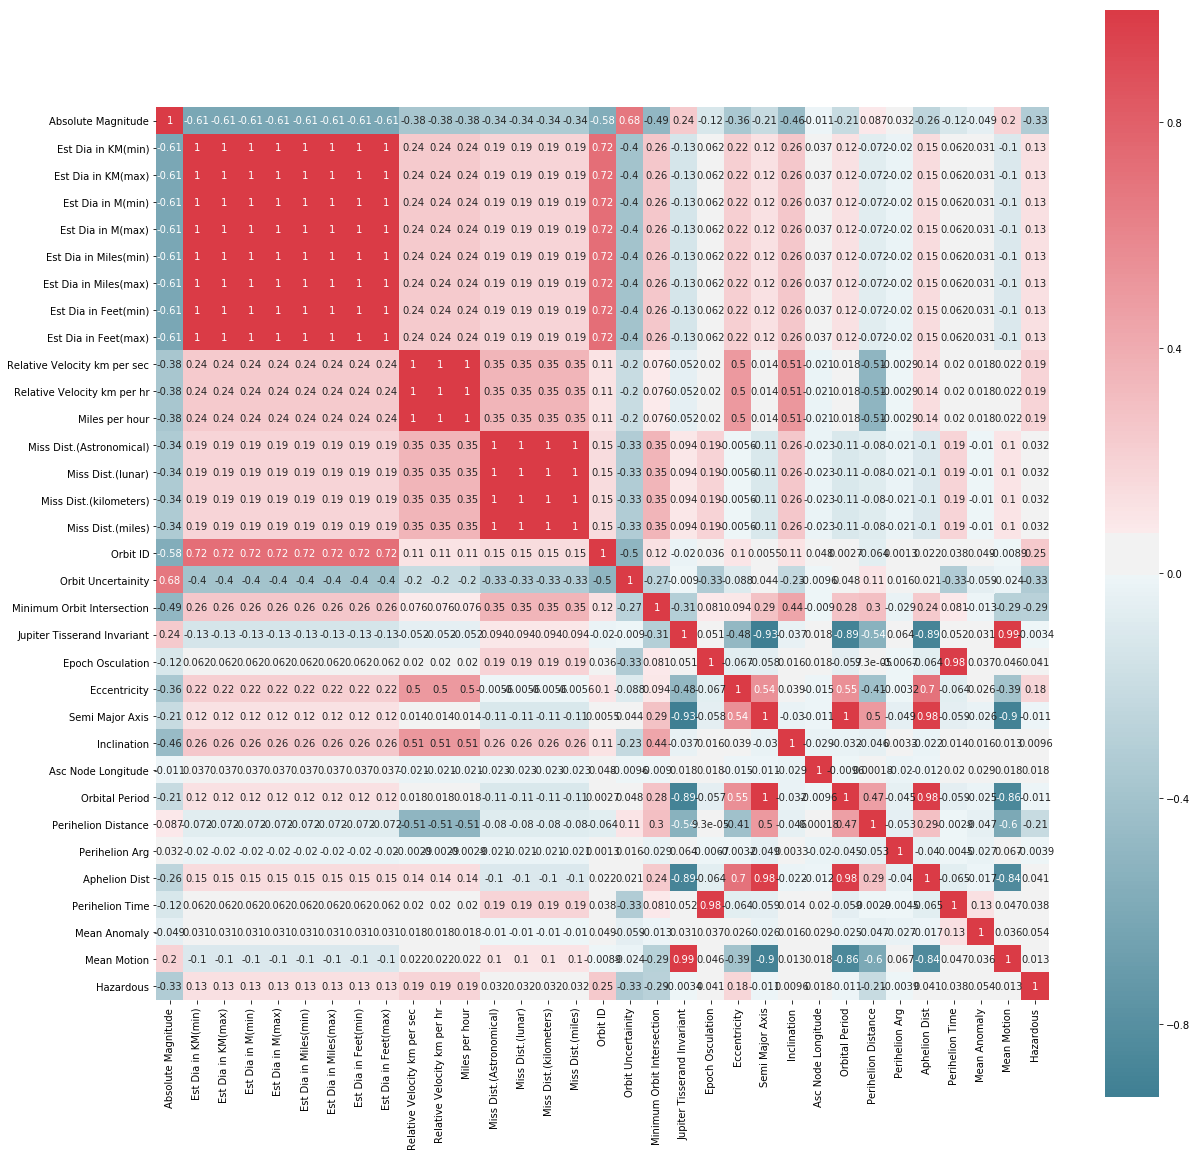

In [117]:
# heatplot
f, ax = plt.subplots(figsize=(20, 20))
corr = dataset.corr("pearson")
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

As suspected, the columns regarding the "Miss Dist", the velocity and the estimated diameter of the meteorite all have a correlation of 1. We can therefore conclude that these features merely contain the same values in a different unit of measurement and that we can discard all columns but one for every physical quantity mentioned. 
It is however still unclear why columns like "Est Dia in M(max)" and "Est Dia in M(min)" have a correlation of 1. 
        A closer inspection of the data as shown below, shows that there is indeed a linear relation between the two features and that we only need to maintain one of the features to conserve all the information in the dataset.

In [118]:
#calculate the relative difference between the two features
diff = (dataset['Est Dia in M(max)'] - dataset['Est Dia in M(min)']) / dataset['Est Dia in M(min)']
print("maximum value is: {0}".format(diff.max()))
print("minimum value is: {0}".format(diff.min()))

maximum value is: 1.236067977550052
minimum value is: 1.2360679774779646


In [119]:
#removal of correlated (correlation equals 1) columns
dataset = dataset.drop(['Est Dia in KM(max)', 'Est Dia in M(min)',
                        'Est Dia in M(max)', 'Est Dia in Miles(min)','Est Dia in Miles(max)','Est Dia in Feet(min)','Est Dia in Feet(max)'], axis=1)
dataset = dataset.drop(['Relative Velocity km per hr','Miles per hour'], axis=1)
dataset = dataset.drop(['Miss Dist.(lunar)','Miss Dist.(kilometers)','Miss Dist.(miles)'], axis=1)

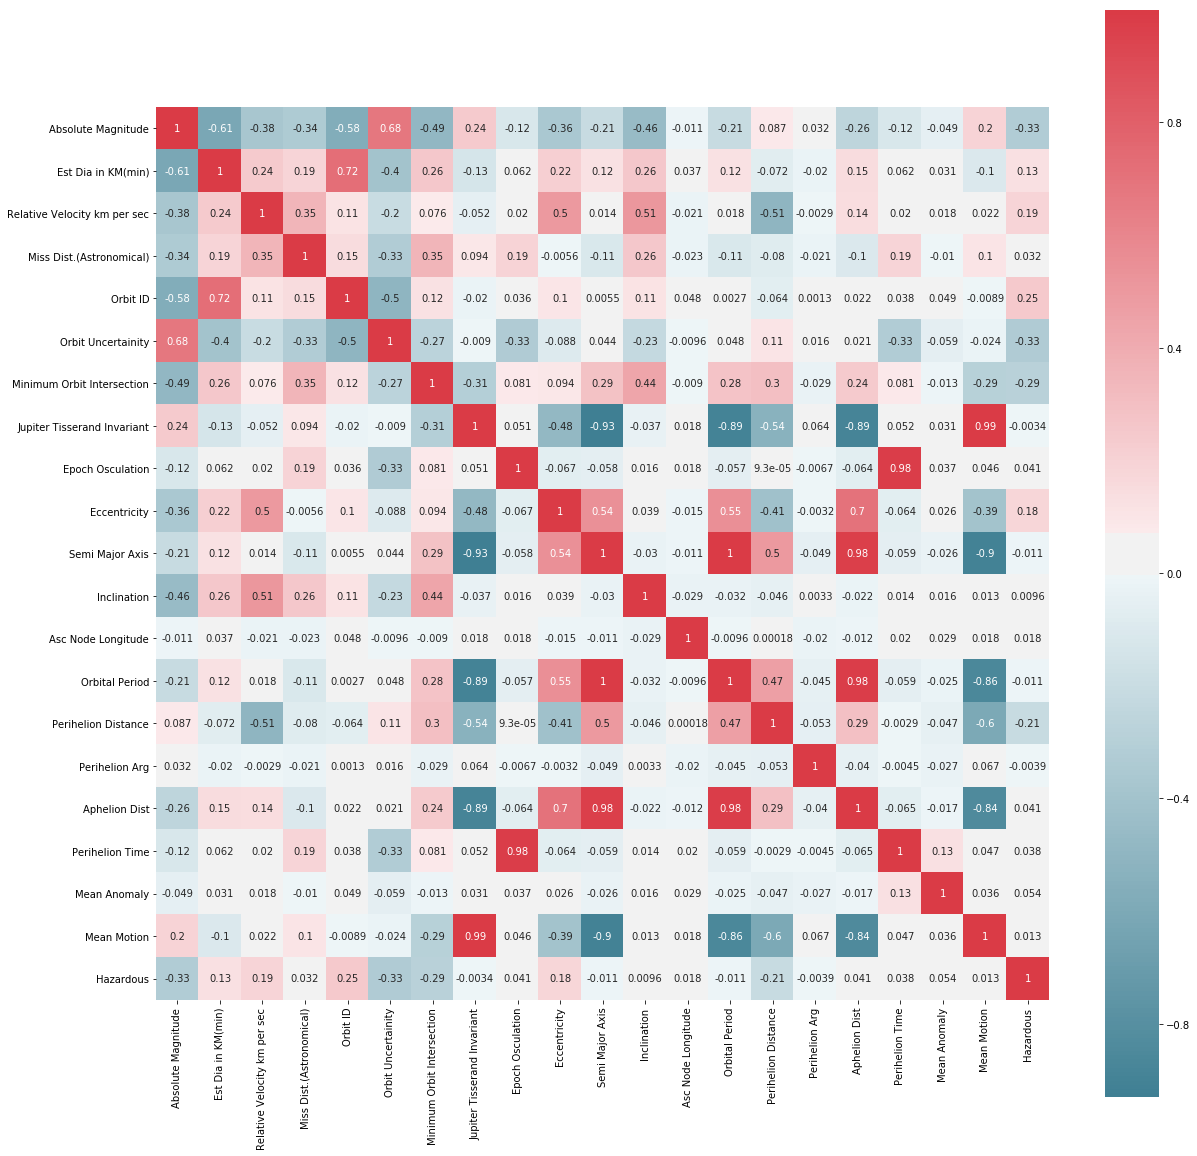

In [120]:
# heatplot
f, ax = plt.subplots(figsize=(20, 20))
corr = dataset.corr("pearson")
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

The new heatmap reveals  additional columns which have a very high correlation. Because the titles reveal no real justification to believe that there is a direct relationship between the features, we will not remove the features from the dataset.

Now we have a dataset with all the relevant features, we can:
* check the dataset for missing values and remove the corresponding samples when found
* check the dataset for duplicate values and remove the corresponding samples when found

In [121]:
#check for missing values
print(dataset.isnull().sum())

Absolute Magnitude              0
Est Dia in KM(min)              0
Relative Velocity km per sec    0
Miss Dist.(Astronomical)        0
Orbit ID                        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis                 0
Inclination                     0
Asc Node Longitude              0
Orbital Period                  0
Perihelion Distance             0
Perihelion Arg                  0
Aphelion Dist                   0
Perihelion Time                 0
Mean Anomaly                    0
Mean Motion                     0
Hazardous                       0
dtype: int64


In [122]:
#check dataset for duplicate samples
dataset.duplicated().value_counts()

False    4687
dtype: int64

As shown above, the dataset contains no missing values or duplicate samples so in this case no extra action is required.

For the second stage of our data exploration we will try to get a better idea of how our data is distributed.

In [123]:
#print the statistical metrics
dataset.describe()

,Absolute Magnitude,Est Dia in KM(min),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
count,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,22.267865,0.204604,13.970811,0.256778,28.300619,3.516962,0.082320,5.056111,2.457724e+06,0.382569,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,2.890972,0.369573,7.293223,0.145798,38.299668,3.078307,0.090300,1.237818,9.202975e+02,0.180444,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,11.160000,0.001011,0.335504,0.000178,1.000000,0.000000,0.000002,2.196000,2.450164e+06,0.007522,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,20.100000,0.033462,8.432865,0.133420,9.000000,0.000000,0.014585,4.049500,2.458000e+06,0.240858,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,21.900000,0.110804,12.917889,0.265029,16.000000,3.000000,0.047365,5.071000,2.458000e+06,0.372450,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,24.500000,0.253837,18.077649,0.384154,31.000000,6.000000,0.123593,6.019000,2.458000e+06,0.512411,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,32.100000,15.579552,44.633747,0.499884,611.000000,9.000000,0.477891,9.025000,2.458020e+06,0.960261,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


Looking at the statistical overview, we notice that for some features the difference between the 75th percentile and the maximum value is remarkable. The "Orbital Period", for instance, has a mean of 635 and a 75th percentile of 794 while the maximumvalue has a value of 4172. This leads to the assumption that some of the features contain one or more outliers. 

<Figure size 432x288 with 0 Axes>

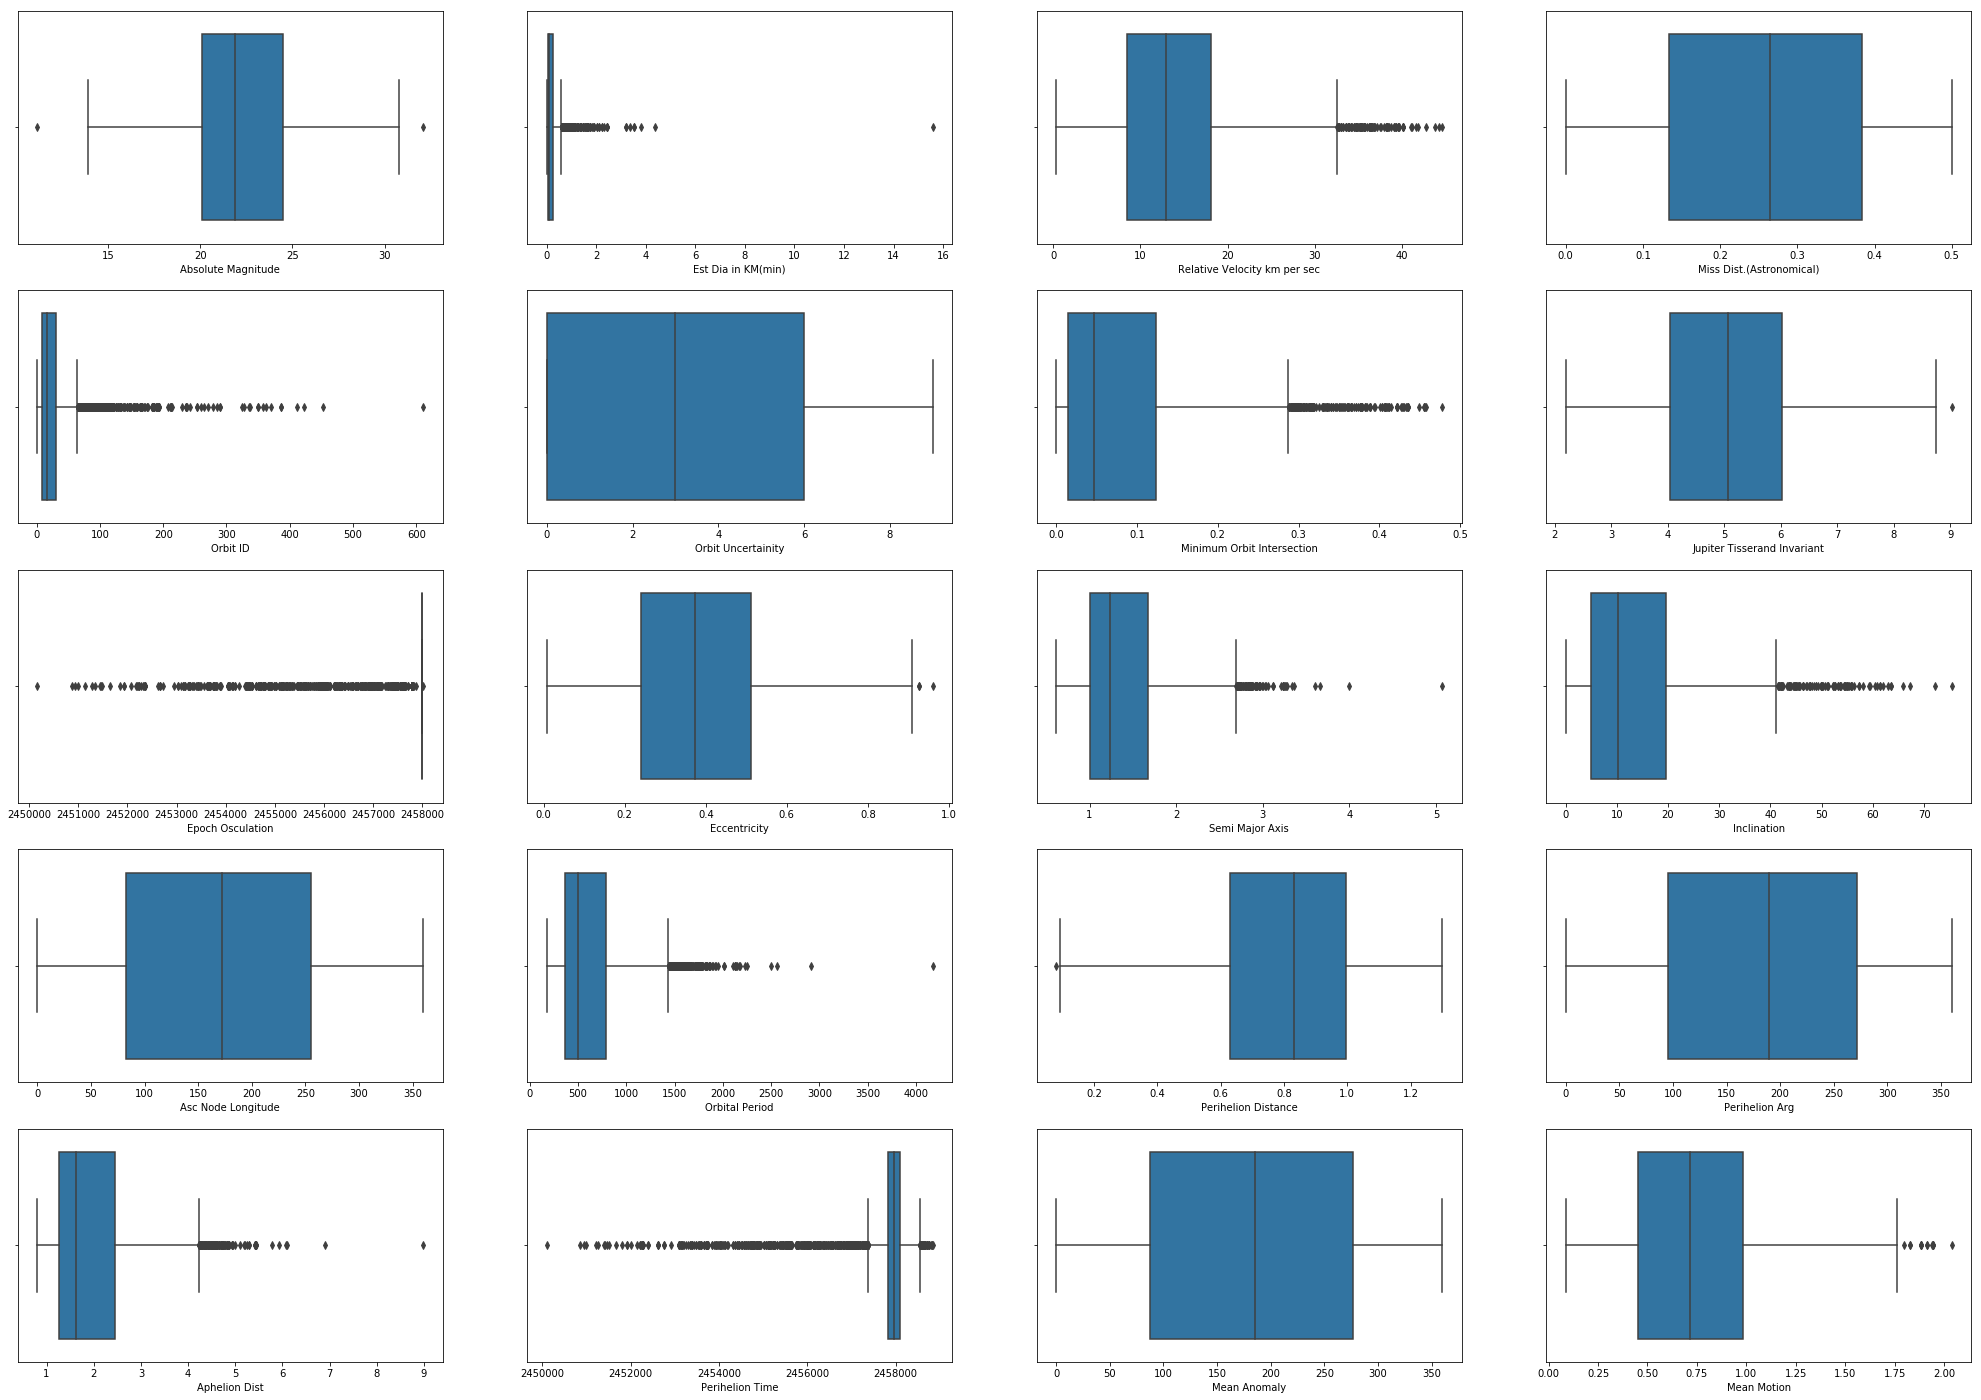

In [124]:
#plot the boxplots of all features
plt.tight_layout(pad=0.9)
plt.figure(figsize=(35,30)) 
plt.subplots_adjust(wspace = 0.2  )
nbr_columns = 4 
nbr_graphs = len(dataset.columns) 
nbr_rows = int(np.ceil(nbr_graphs/nbr_columns)) 
columns = list(dataset.columns.values) 
for i in range(0,len(columns)-1): 
    plt.subplot(nbr_rows,nbr_columns,i+1) 
    ax1=sns.boxplot(x= columns[i], data= dataset, orient="h") 

plt.show() 

The boxplots confirm our previous assumption. Features like "Orbital Period" and "Perihelion Time" show a significant amount of outliers. Because it is not clear whether these outliers are meaningful or not we will not remove them from the dataset just yet.

(Note: The feature orbit id contains categorical or label values and should therefore not be taken into account when evaluating the above boxplots.)

Finally we will take a look at the distribution of de sample labels. The countplot below shows that the distribution of dataset labels is unbalanced with nearly 4000 non hazardous and only 755 hazardous asteroids. We will need to take this into account when we evaluate our models because a model that, for example, labels every asteroid as "non hazardous" will already achieve an accuracy score of 3932/4687 = 84%. It is therefore necessary to pay extra attention to other model metrics like the models Precision, Recall and Confusion Matrix.

label balance:
False    3932
True      755
Name: Hazardous, dtype: int64


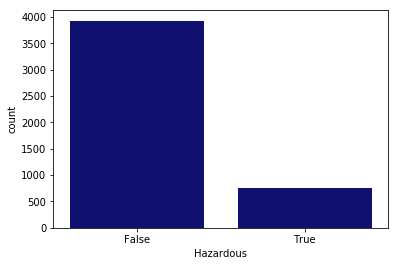

In [125]:
#countplot of labels
print("label balance:")
print(dataset.Hazardous.value_counts())

ax1=sns.countplot(dataset.Hazardous,color="navy")

# Data Preparation
### One hot encoding of categorical features

As mentioned before, the feature "Orbit ID" is a categorical variable. Because our models cannot operate on categorical data directly, we will have to convert them into a numerical equivalent through the use of one hot encoding. This will create an extra column for every category and fill all columns with zero values except for the index of the category, which is marked with a 1.

### Make labels numerical

Besides the one hot encoding of the categorical features we still have a label column which contains the labels "true" and "false". These labels will have to be converted into a binary numerical value for the models to interpret them correctly. 

In [126]:
# one-hot encoding of 'Orbit ID'
dataset = pd.concat([dataset,pd.get_dummies(dataset['Orbit ID'], prefix='Orbit_ID')],axis=1)

dataset.drop(['Orbit ID'],axis=1, inplace=True)
dataset.head()

,Absolute Magnitude,Est Dia in KM(min),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,...,Orbit_ID_337,Orbit_ID_350,Orbit_ID_358,Orbit_ID_362,Orbit_ID_370,Orbit_ID_386,Orbit_ID_412,Orbit_ID_422,Orbit_ID_453,Orbit_ID_611
0,21.6,0.127220,6.115834,0.419483,5,0.025282,4.634,2458000.5,0.425549,1.407011,...,0,0,0,0,0,0,0,0,0,0
1,21.3,0.146068,18.113985,0.383014,3,0.186935,5.457,2458000.5,0.351674,1.107776,...,0,0,0,0,0,0,0,0,0,0
2,20.3,0.231502,7.590711,0.050956,0,0.043058,4.557,2458000.5,0.348248,1.458824,...,0,0,0,0,0,0,0,0,0,0
3,27.4,0.008801,11.173874,0.285322,6,0.005512,5.093,2458000.5,0.216578,1.255903,...,0,0,0,0,0,0,0,0,0,0
4,21.6,0.127220,9.840831,0.407832,1,0.034798,5.154,2458000.5,0.210448,1.225615,...,0,0,0,0,0,0,0,0,0,0


In [127]:
# Make labels in column "Hazardous" numerical: False / True -> 0 / 1
dataset['Hazardous'] = pd.factorize(dataset['Hazardous'], sort=True)[0]
print(dataset.Hazardous[0:5])

0    1
1    0
2    1
3    0
4    1
Name: Hazardous, dtype: int64


### Standardising the dataset and splitting up labels and features

Before we can begin with training the model, we still need to separate the labels from the features.  

Furthermore, we know that many machine learning algorithms perform better when our features are on a relatively similar scale and/or close to normally distributed, so it is a good idea to standardize our feature data. Because of the fact that we previously discovered the presence of outliers we will use the scikit learn robust scaler to standardize our data. However, we want to preserve the one hot encoded categories of the "Orbit ID", so we will have to temporarily remove these columns from the featureset. Finally, we will merge all the features back together into one numpy array. 

In [128]:
# separating the classlabels from the features  
y = dataset.Hazardous.values
X = dataset.drop(['Hazardous'],axis=1)

In [129]:
# split the featureset into the numerical and one hot encoded columns
X_num = X.loc[:,'Absolute Magnitude':'Mean Motion']
X_One_Hot = X.loc[:,'Orbit_ID_1':].values

# Standardize the numerical features with the Robust Scaler
from sklearn.preprocessing import RobustScaler
RbS = RobustScaler().fit(X_num)
X_num = RbS.transform(X_num)

# merge all features back together in one numpy array
X = np.concatenate((X_num,X_One_Hot),axis=1)

# Training the classifiers

### Logistic regression
We start by splitting up the dataset in a 3 to 1 ratio, training and test set and train a simple logistic regression model that we can use as a starting point for finding a good functioning model. We can then try other machine learning algorithms to find the model which achieves the best results.    

For all models we will log the training time needed, the accuracy, precision and recall of the model so we can get an overview of which model performs best. 


In [130]:
# Split up the dataset into a training and a test set with a 1000 waarden in test set en random_state = 0. Normaliseer de features.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


#Function to train a model and log the metrics
def train_model(model,X_train, y_train, X_test,y_test):
    
    start_time = time.time()
    model.fit(X_train, y_train)
    
    delta_time = (time.time() - start_time)
    y_predict = model.predict(X_test)
    acc_model = accuracy_score(y_test, y_predict)
    prec_model = precision_score(y_test, y_predict,average= None)
    recall_model = recall_score(y_test, y_predict,average= None)
    log = np.array([[acc_model,prec_model[0],prec_model[1],recall_model[0],recall_model[1],delta_time]])
    
    print("training time: {0}".format(delta_time))
    print("accuracy: {0}".format(acc_model))
    print("\nconfusion matrix: ")
    print("-----------------------")
    print(confusion_matrix(y_test, y_predict))
    target_names = ['Not hazardous', 'Hazardous']
    print("\nclassification report:")
    print("-----------------------")
    print(classification_report(y_test, y_predict,target_names=target_names))
       
    return model, log

In [131]:
# Train and test the logistic regression classifier
Log_reg_model = linear_model.LogisticRegression(C=0.001, solver='lbfgs', multi_class='auto')
Log_reg_model, model_log = (train_model(Log_reg_model,X_train, y_train, X_test,y_test))

training time: 0.12134575843811035
accuracy: 0.840443686006826

confusion matrix: 
-----------------------
[[984   0]
 [187   1]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.84      1.00      0.91       984
    Hazardous       1.00      0.01      0.01       188

     accuracy                           0.84      1172
    macro avg       0.92      0.50      0.46      1172
 weighted avg       0.87      0.84      0.77      1172



As expected, our simple logistic regression model is not capable of distuingishing the hazardous from the non hazardous asteroids. It simply classifies every asteroid as being non hazardous. The dataset is, as mentioned before, too unbalanced for this model to classify the samples correctly.
      
In order to try and find a better model, we will try out the following kinds of machine learning algorithms:  

* Logistic regression with gridsearch
* SVM with gridsearch
* Random Forest Classifier
* Logistic Regression with AdaBoost

In [132]:
# Train a logistic regression model through cross-validation en GridSearch 
#--------------------------------------------------------------------------

parameters =  {'C' : [0.1, 1, 10, 100], 
              'class_weight': [None,'balanced'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}
             
Grid_Log_model = GridSearchCV(estimator = LogisticRegression(), 
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 6,
                           n_jobs = -1)

Grid_Log_model,log = train_model(Grid_Log_model,X_train, y_train, X_test,y_test)
model_log= np.append(model_log,log,axis=0)

training time: 25.288625240325928
accuracy: 0.9650170648464164

confusion matrix: 
-----------------------
[[964  20]
 [ 21 167]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.98      0.98      0.98       984
    Hazardous       0.89      0.89      0.89       188

     accuracy                           0.97      1172
    macro avg       0.94      0.93      0.93      1172
 weighted avg       0.96      0.97      0.96      1172



In [133]:
# Train a Support Vector Machine
from sklearn.svm import SVC

parameters = {'C' : [8,9, 10, 11, 12,13, 14], 
              'kernel' : ['linear', 'rbf'],
              'degree': [1],
              'gamma': (0.01, 0.1,1)}
             
#SVC_model = GridSearchCV(estimator = SVC(), 
#                           param_grid = parameters,
#                           scoring = 'accuracy',
#                           cv = 6,
#                           n_jobs = -1)

SVC_model= SVC(C=20, degree=3, gamma='auto', kernel='rbf')

SVC_model,log = train_model(SVC_model,X_train, y_train, X_test,y_test)
model_log= np.append(model_log,log,axis=0)

training time: 0.9583461284637451
accuracy: 0.9513651877133106

confusion matrix: 
-----------------------
[[963  21]
 [ 36 152]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.96      0.98      0.97       984
    Hazardous       0.88      0.81      0.84       188

     accuracy                           0.95      1172
    macro avg       0.92      0.89      0.91      1172
 weighted avg       0.95      0.95      0.95      1172



In [134]:
# Train a Random Forest Classifier
number_of_trees = 1000
max_number_of_features = 15

RFC_model = RandomForestClassifier(n_estimators=number_of_trees, max_features=max_number_of_features)

RFC_model,log = train_model(RFC_model,X_train, y_train, X_test,y_test)
model_log= np.append(model_log,log,axis=0)

training time: 5.223965167999268
accuracy: 0.9940273037542662

confusion matrix: 
-----------------------
[[984   0]
 [  7 181]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.99      1.00      1.00       984
    Hazardous       1.00      0.96      0.98       188

     accuracy                           0.99      1172
    macro avg       1.00      0.98      0.99      1172
 weighted avg       0.99      0.99      0.99      1172



In [135]:
# Boosting
# Boosting met logistic regression

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

number_of_estimators = 200
complexity = 10
cart = cart = LogisticRegression(solver='lbfgs', C=complexity)
ADA_model = BaggingClassifier(base_estimator=cart, n_estimators=number_of_estimators)

ADA_model,log = train_model(ADA_model,X_train, y_train, X_test,y_test)
model_log= np.append(model_log,log,axis=0)

training time: 25.548920154571533
accuracy: 0.9522184300341296

confusion matrix: 
-----------------------
[[964  20]
 [ 36 152]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.96      0.98      0.97       984
    Hazardous       0.88      0.81      0.84       188

     accuracy                           0.95      1172
    macro avg       0.92      0.89      0.91      1172
 weighted avg       0.95      0.95      0.95      1172



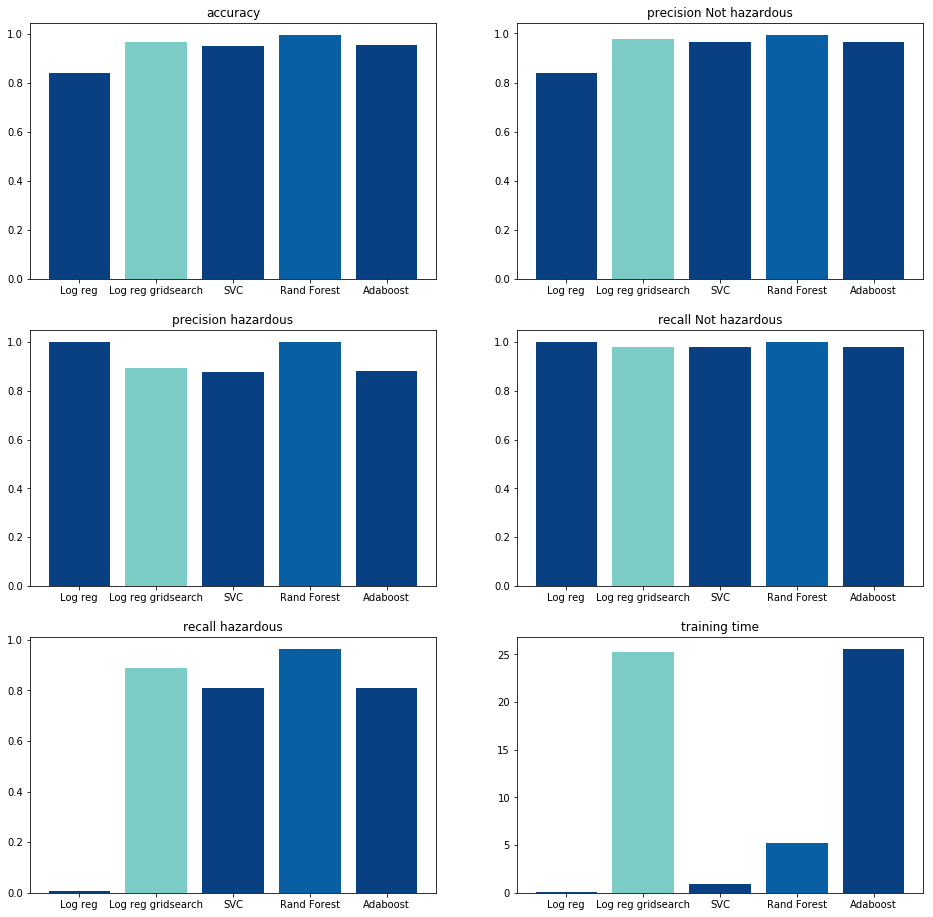

In [136]:
model_names = ('Log reg', 'Log reg gridsearch','SVC','Rand Forest', 'Adaboost')
column_names = ('accuracy','precision Not hazardous','precision hazardous','recall Not hazardous','recall hazardous','training time')

plt.figure(figsize=(16,16)) 
colors=[1000,500,1000,900]
colors = [x / max(colors) for x in colors]
my_cmap = plt.cm.get_cmap('GnBu')
colors = my_cmap(colors)
for i in range(0,6): 
    plt.subplot(3,2,i+1) 
    ax=plt.bar(x=model_names,height=model_log[:,i],color=colors)
    plt.title(column_names[i])
plt.show()

In [137]:
pd.DataFrame(data=model_log,index=model_names,columns=column_names)

,accuracy,precision Not hazardous,precision hazardous,recall Not hazardous,recall hazardous,training time
Log reg,0.840444,0.840307,1.000000,1.000000,0.005319,0.121346
Log reg gridsearch,0.965017,0.978680,0.893048,0.979675,0.888298,25.288625
SVC,0.951365,0.963964,0.878613,0.978659,0.808511,0.958346
Rand Forest,0.994027,0.992936,1.000000,1.000000,0.962766,5.223965
Adaboost,0.952218,0.964000,0.883721,0.979675,0.808511,25.548920


Looking at the results of the different models, we notice that by using gridsearch, we were able to drastically inmprove the performance of the logistic regression model. 
Where the original model was not capable of detecting the hazardous asteroids, our new Logistic Regression model is able to detect aprox 167 out of 177 hazardous asteroids.
The gridsearch however requires a lot of training time. This is due to the fact that for each of the possible combinations of our hyperparameters, the model gets retrained to find the specific combination of hyperparameters that gives us the best performing model.

Overall we can conclude that our Random Forest classifier is able to achieve the best results compared to the other models. Let's see if we can find a way to tune the RFC so we get an even better performing model.  


# Tuning the Random Forest Classifier
We will start by determining which features are being perceived as the most significant by our RFC-model. We can simply do this by extracting the feature importances from our model and plot their importance in sorted order. 

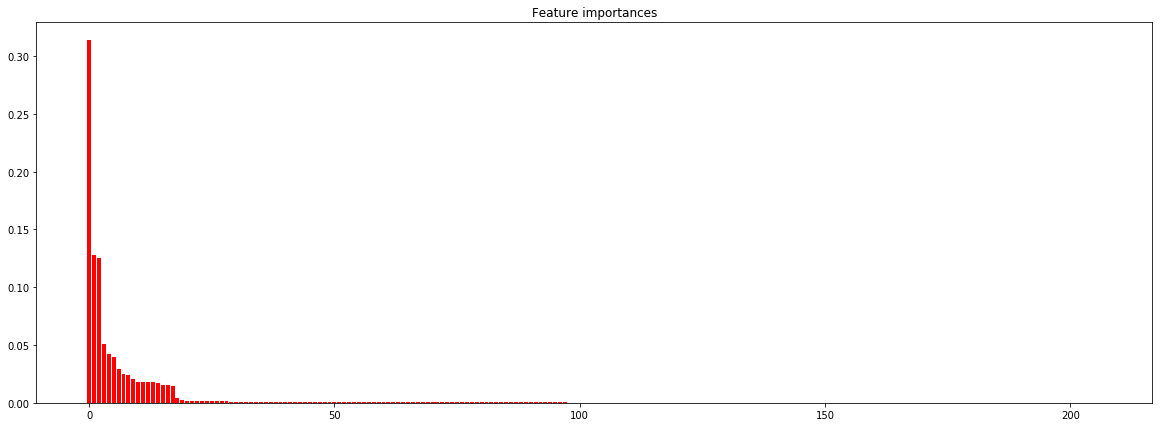

In [138]:
importances = RFC_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,7))
plt.title("Feature importances")
ax = plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")

plt.show()

The chart clearly shows that out of our 207 features, most of them contain little or no relevant information for classifying the testsamples. The fact that we include all these irrelevant features in our data will have a negative impact on the training and performance of our model. After all, a Random Forest Classifier is a model containing multiple decision trees which are trained over a random extraction of the samples and a random extraction of the features. This means that not every tree sees all the features or all the observations. If one or more of these decision trees is only exposed to irrelevant features, it will not be able to make a meaningful contribution to the classification of the samples.

So lets see if we can improve the models performance by only using the 10 most relevant features to retrain our model.

In [139]:
#removal of all but 10 most relevant features
least_important_feat_10=importances.argsort()[:-10]
X_red_10 = np.delete(X,least_important_feat_10,1)
print(X_red_10.shape)

(4687, 10)


In [140]:
# Split up the dataset into a training and a test set
X_train_red_10, X_test_red_10, y_train_red_10, y_test_red_10 = train_test_split(X_red_10, y, test_size=0.25, random_state=0)

In [141]:
# Train a Random Forest Classifier
number_of_trees = 1000
max_number_of_features = 9

RFC_model_red = RandomForestClassifier(n_estimators=number_of_trees, max_features=max_number_of_features)

RFC_model_red,log = train_model(RFC_model_red,X_train_red_10, y_train_red_10, X_test_red_10,y_test_red_10)
model_log= np.append(model_log,log,axis=0)

training time: 5.3963799476623535
accuracy: 0.9931740614334471

confusion matrix: 
-----------------------
[[984   0]
 [  8 180]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.99      1.00      1.00       984
    Hazardous       1.00      0.96      0.98       188

     accuracy                           0.99      1172
    macro avg       1.00      0.98      0.99      1172
 weighted avg       0.99      0.99      0.99      1172



By reducing the number of features to only the ten most significant ones, we are able to match the model metrics of our previous RFC. 
Because we now only have 10 features left, we can use a pairplot to visualise the relationships between the various features.   

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


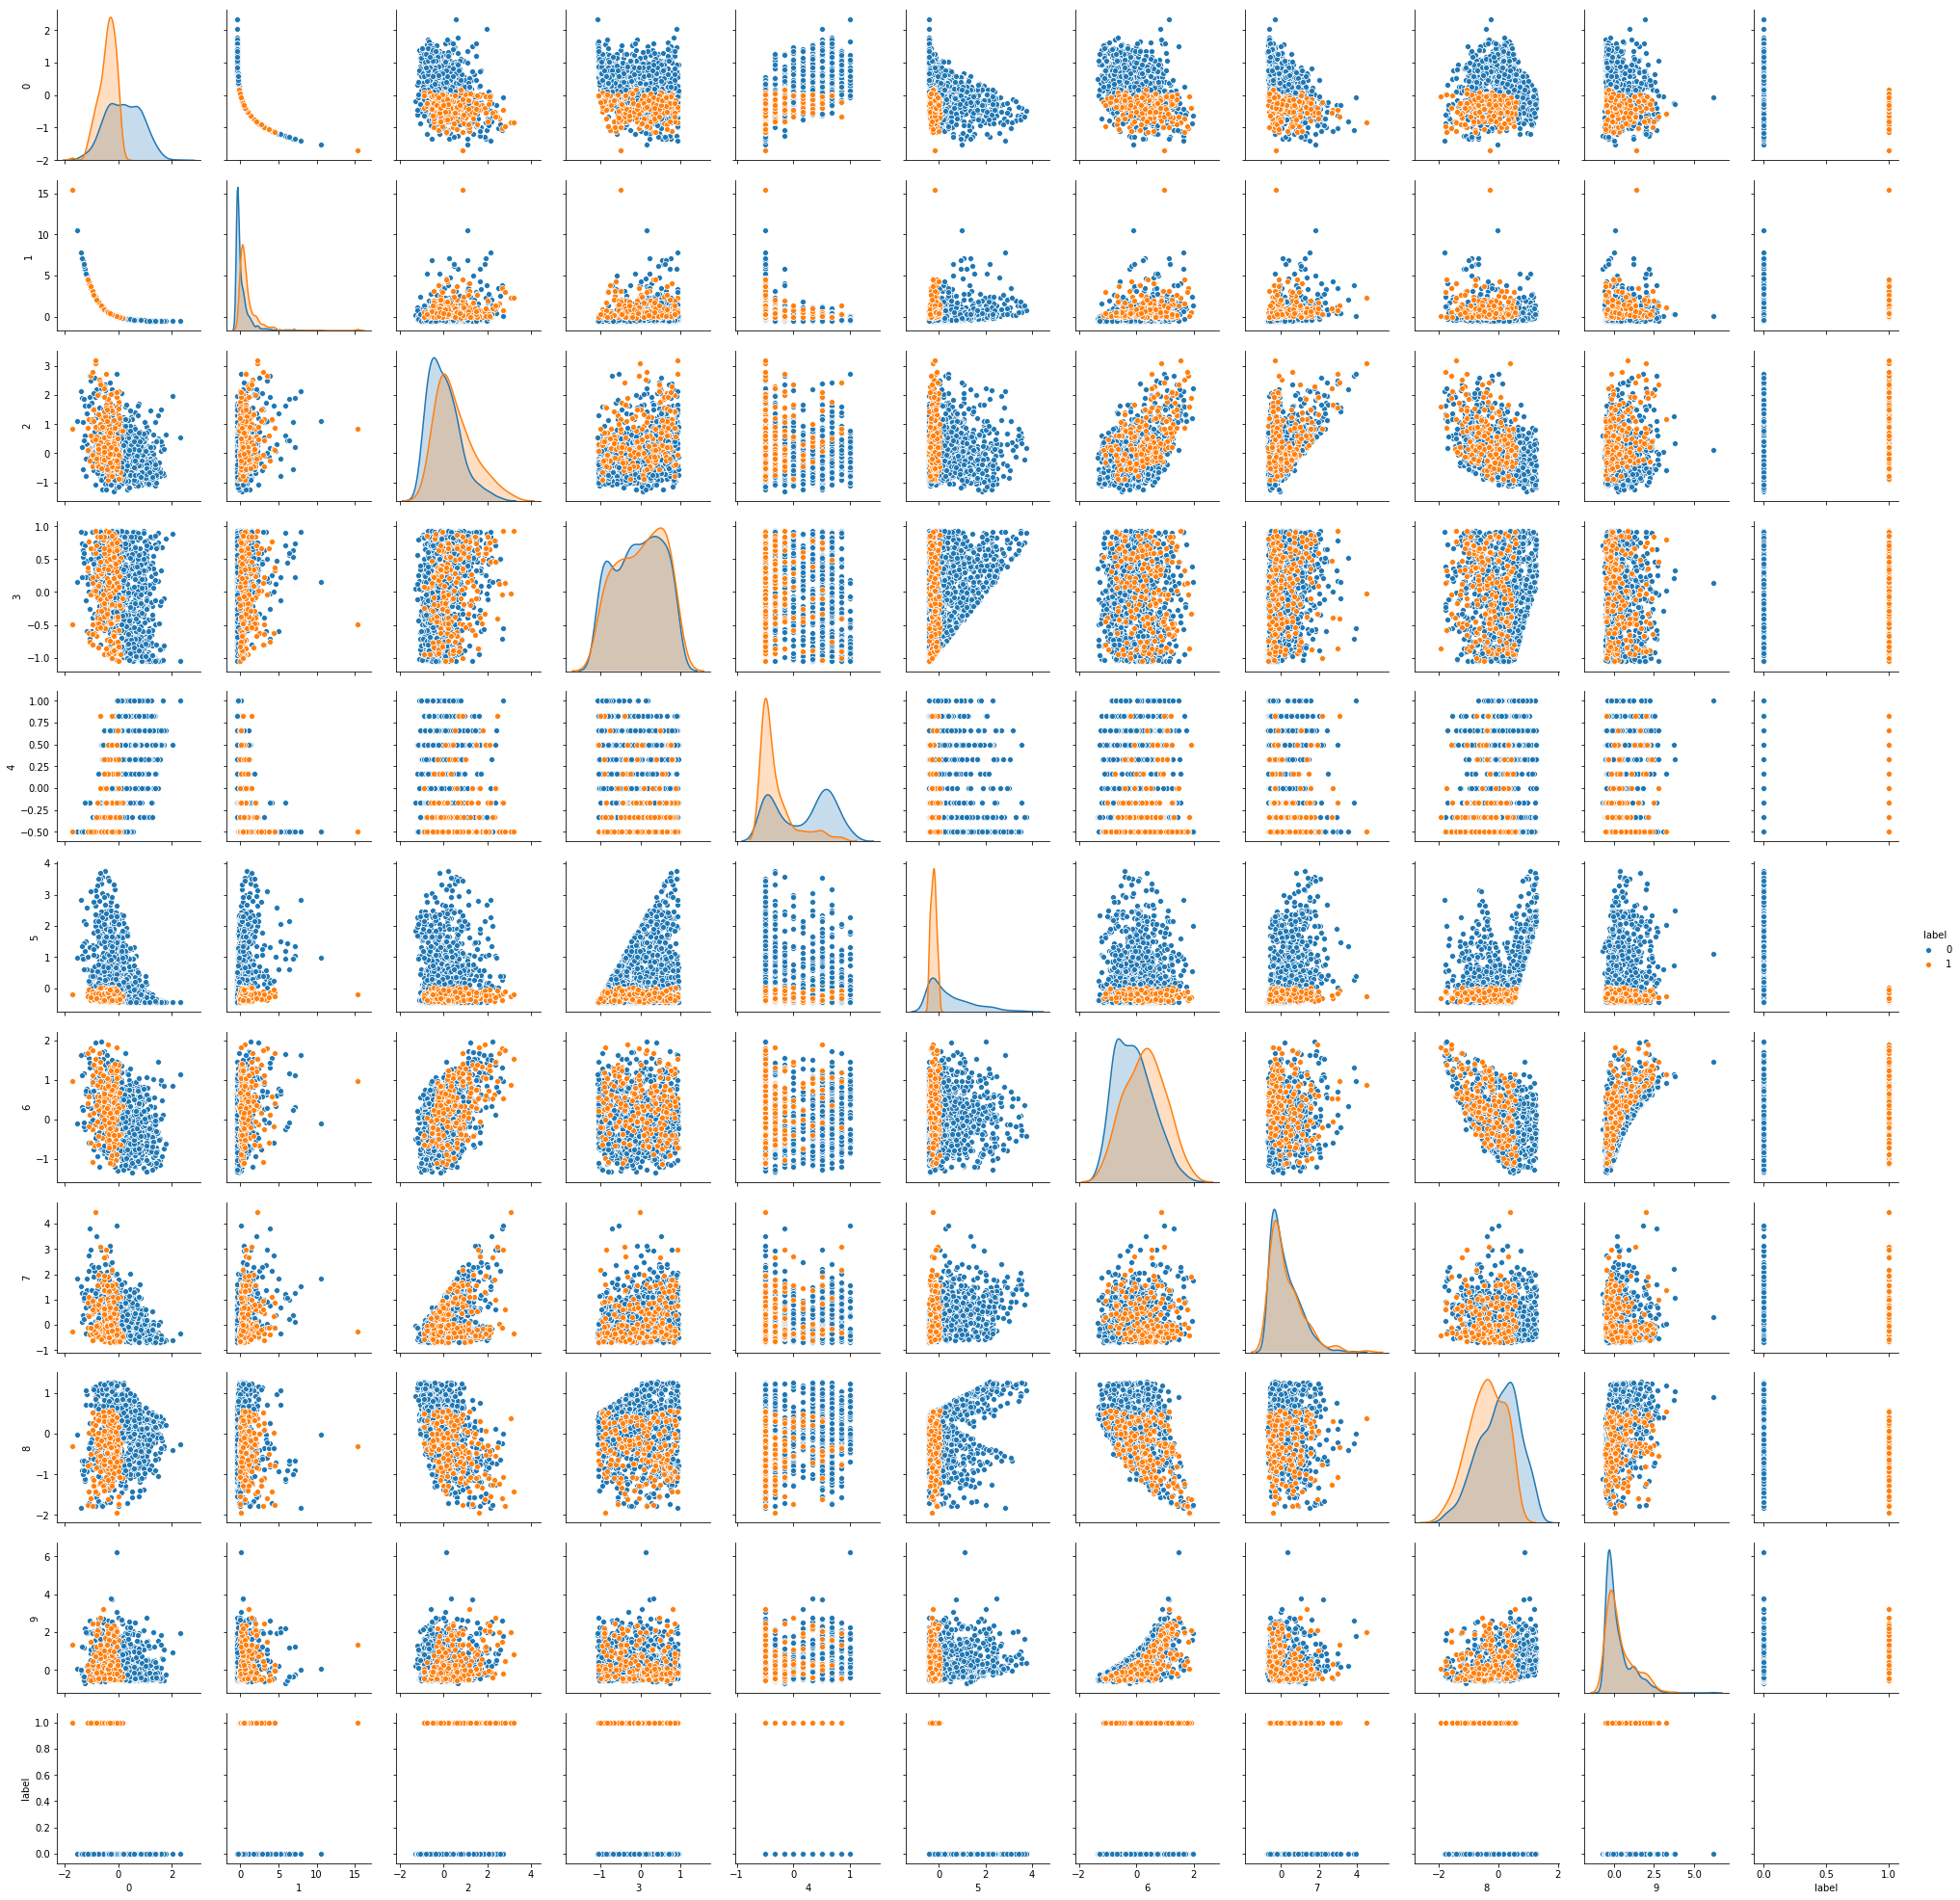

In [142]:
#visualise the pairplot of the ten most significant features
ds = pd.DataFrame(X_test_red_10)
ds['label']= y_test_red_10
sns.pairplot(ds, hue="label")

A quick look at the pairplot shows that for some of the feature pairs, there is no clear boundary between the two categories. So therefore we will just try to reduce the amount of features even further and just keep the two most significant ones. Because we will only use 2 features we will also be able to visualise the RFC boundary between the two classes.

In [143]:
#removal of all but the 2 most relevant features
least_important_feat_2=importances.argsort()[:-2]
X_red_2 = np.delete(X,least_important_feat_2,1)
print(X_red_2.shape)

(4687, 2)


In [144]:
# Split up the dataset into a training and a test set
X_train_red_2, X_test_red_2, y_train_red_2, y_test_red_2 = train_test_split(X_red_2, y, test_size=0.25, random_state=0)

In [145]:
# Train a Random Forest Classifier
number_of_trees = 1000
max_number_of_features = 2

RFC_model_red_2 = RandomForestClassifier(n_estimators=number_of_trees, max_features=max_number_of_features)

RFC_model_red_2,log = train_model(RFC_model_red_2,X_train_red_2, y_train_red_2, X_test_red_2,y_test_red_2)
model_log= np.append(model_log,log,axis=0)

training time: 2.162571668624878
accuracy: 0.9957337883959044

confusion matrix: 
-----------------------
[[984   0]
 [  5 183]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.99      1.00      1.00       984
    Hazardous       1.00      0.97      0.99       188

     accuracy                           1.00      1172
    macro avg       1.00      0.99      0.99      1172
 weighted avg       1.00      1.00      1.00      1172



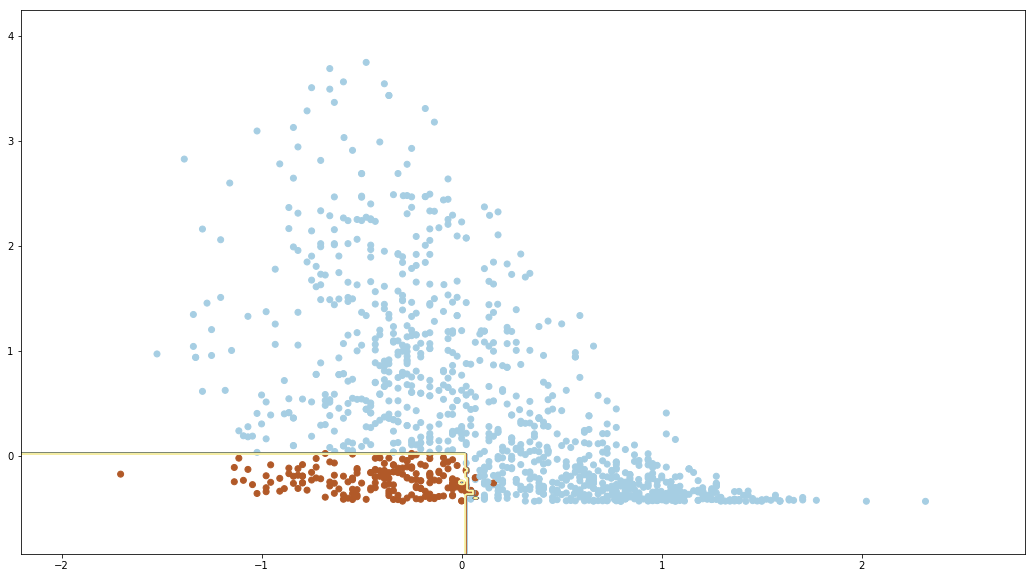

In [146]:
#plotting the two most signifcant features for the testsamples including the RFC boundaries

def plot_2D_boundary(model,X_test):
    h = .01
    plt.figure(figsize=(18,10))

    x_min, x_max = X_test_red_2[:, 0].min() - 0.5, X_test_red_2[:, 0].max() + 0.5
    y_min, y_max = X_test_red_2[:, 1].min() - 0.5, X_test_red_2[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X_test_red_2[:, 0], X_test_red_2[:, 1], c=y_test_red_2, cmap=plt.cm.Paired)

plot_2D_boundary(RFC_model_red_2,X_test_red_2)

Using only 2 features results in an even better performance of our classifying model. In this case we only get 5 false negatives and no false positives. The scatterplot clearly shows how the RFC boundary divides the samples almost perfectly. 
However, using a Random Forest with 1000 decision trees where all the decision trees can only use the two given features, is not very efficient. After all, all decision trees in the RFC will use the same boundaries to divide the samples so using a single decision tree should lead to the same result at a much lower computational cost. To prove this we will train a simple decision tree with only the same 2 most significant features.

In [147]:
#Training of a decision tree using the two most significant features
from sklearn import tree
detr_model = tree.DecisionTreeClassifier()
detr_model,log = train_model(detr_model,X_train_red_2, y_train_red_2, X_test_red_2,y_test_red_2)
model_log= np.append(model_log,log,axis=0)

training time: 0.0041751861572265625
accuracy: 0.9957337883959044

confusion matrix: 
-----------------------
[[984   0]
 [  5 183]]

classification report:
-----------------------
               precision    recall  f1-score   support

Not hazardous       0.99      1.00      1.00       984
    Hazardous       1.00      0.97      0.99       188

     accuracy                           1.00      1172
    macro avg       1.00      0.99      0.99      1172
 weighted avg       1.00      1.00      1.00      1172



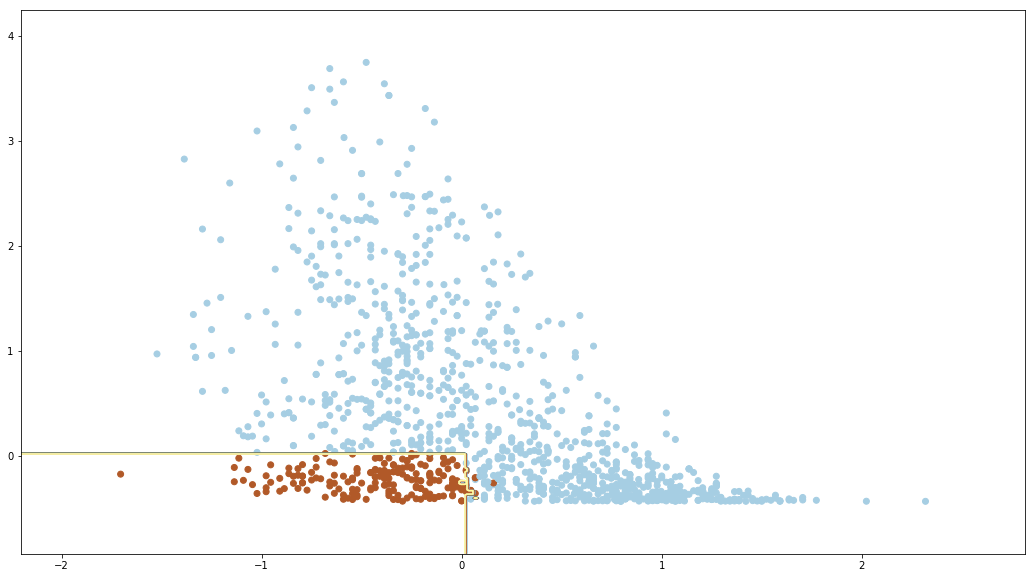

In [148]:
plot_2D_boundary(detr_model,X_test_red_2)

# Concluding

The above test clearly shows that a simple decision tree produces exactly the same result as the previously trained RFC. It is therefore clear that in this case it is not because of the use of the ensemble techniques that we achieve such a high result, but that by reducing the number of features to these 2, we force the model to focus on these 2 features. The question that naturally arises is why the first RFC model itself failed to focus on these 2 features.
 
As already mentioned, with an RFC each tree will only have a subset of the features available to determine the optimum split in each node (in Scikit Learn this is the square root of the total number of features). When the number of features becomes bigger (as in our case 145 features) a large amount of trees in the RFC have no access to the most significant features and therefore cannot make optimum splits. So when we only offer the best features, they will be used more often and the model will score better.
